# Lightning: dask.delayed and dask Futures

This notebook provides a quick introduction to two powerful Dask features for parallelizing arbitrary Python code:

- **`dask.delayed`**: Lazy evaluation - builds a computation graph, executes on `.compute()`
- **`dask.futures`**: Eager execution - starts immediately when submitted, returns Future objects

**Key Difference**: Delayed is lazy (graph-based, batch workflows), while futures are eager (immediate execution, interactive).

In [1]:
from dask.distributed import Client
from time import sleep
import dask

client = Client(n_workers=2)  # Small cluster for demo
client


2025-11-12 13:49:45,152 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cl/mbdp3zfx4cg9mmnz60g052540000gn/T/dask-worker-space/worker-zaup4iod', purging
2025-11-12 13:49:45,153 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/cl/mbdp3zfx4cg9mmnz60g052540000gn/T/dask-worker-space/worker-foj9ugkh', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56610,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56617,Total threads: 5
Dashboard: http://127.0.0.1:56619/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:56613,


## dask.delayed: Lazy Evaluation

`dask.delayed` builds a computation graph but doesn't execute until you call `.compute()`. This is perfect for:
- For-loops that can be parallelized
- Workflows with dependencies
- Batch processing tasks


In [2]:
# Sequential baseline - this runs one after another
def process(x):
    sleep(0.5)
    return x * 2

%time results = [process(i) for i in range(4)]
print("Results:", results)


CPU times: user 137 ms, sys: 31.8 ms, total: 169 ms
Wall time: 2.01 s
Results: [0, 2, 4, 6]


In [3]:
# Parallelize with delayed - builds graph immediately, executes on compute()
@dask.delayed
def process(x):
    sleep(0.5)
    return x * 2

%time delayed_results = [process(i) for i in range(4)]
print("Type:", type(delayed_results[0]))
print("Nothing executed yet! Now compute...")
%time final = dask.compute(*delayed_results)
print("Results:", final)


CPU times: user 284 μs, sys: 131 μs, total: 415 μs
Wall time: 400 μs
Type: <class 'dask.delayed.Delayed'>
Nothing executed yet! Now compute...
CPU times: user 96.7 ms, sys: 41.7 ms, total: 138 ms
Wall time: 617 ms
Results: (0, 2, 4, 6)


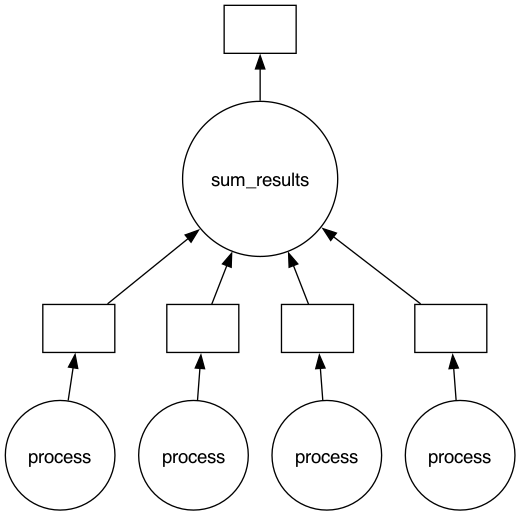

In [4]:
# Visualize the computation graph
# Create a composite operation to show the full graph
@dask.delayed
def sum_results(results):
    return sum(results)

delayed_sum = sum_results(delayed_results)
delayed_sum.visualize()


### Meanings of symbols in visualization
* Circles: functions/methods
* Squares: data - product of function/method


## dask.delayed with Dependencies

Dask automatically handles dependencies in the computation graph. Tasks that depend on others will wait for their inputs to be rea

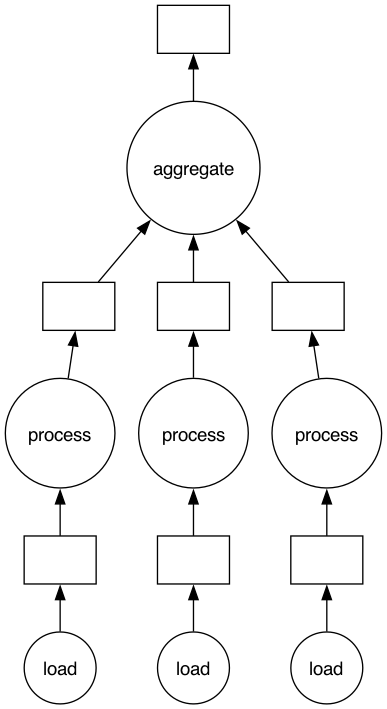

In [5]:
@dask.delayed
def load(filename):
    sleep(0.3)
    return f"data_{filename}"

@dask.delayed
def process(data):
    sleep(0.5)
    return data.upper()

@dask.delayed
def aggregate(results):
    sleep(0.2)
    return len(results)

# Build graph with dependencies
files = ['a', 'b', 'c']
loaded = [load(f) for f in files]
processed = [process(d) for d in loaded]
result = aggregate(processed)

# Visualize the dependency graph
result.visualize()


In [6]:

# Execute
%time result_value = result.compute()
print("Result:", result_value)


CPU times: user 71.8 ms, sys: 20.1 ms, total: 91.9 ms
Wall time: 1.05 s
Result: 3


## dask.futures: Eager Execution

`dask.futures` provides eager, non-blocking execution. Tasks start immediately when submitted and return Future objects. Perfect for:
- Interactive work
- Real-time monitoring
- Streaming computations
    

In [7]:
def process(x):
    sleep(0.5)
    return x * 2

# Submit immediately - returns Future objects right away
futures = [client.submit(process, i) for i in range(4)]
print("Futures:", futures)
print("\nStatuses:", [f.status for f in futures])


Futures: [<Future: pending, key: process-e665e2b79bcbeffee595ce72e860f3da>, <Future: pending, key: process-8c39df0b69c9c71df85de387010be683>, <Future: pending, key: process-ce9dd570a2c64428bd3df4a6a736e652>, <Future: pending, key: process-0d4d755c7e99869608fa1f0ac83e66d6>]

Statuses: ['pending', 'pending', 'pending', 'pending']


In [8]:
# Get results - blocking and non-blocking methods

# Non-blocking: check if done
print("First future done?", futures[0].done())
print("First future status:", futures[0].status)

# Blocking: wait for result
result = futures[0].result()
print("First result:", result)

# Get all results (blocks until all complete)
results = [f.result() for f in futures]
print("All results:", results)


First future done? False
First future status: pending
First result: 0
All results: [0, 2, 4, 6]


In [9]:
# Real-time monitoring example
future = client.submit(process, 10)

# Do other work while it runs
print("Future status:", future.status)
print("Future done:", future.done())

# Wait a moment and check again
import time
time.sleep(0.6)
print("\nAfter 0.6s:")
print("Future status:", future.status)
print("Future done:", future.done())

# Get result when ready (blocks if not done)
result = future.result()
print("Final result:", result)


Future status: pending
Future done: False

After 0.6s:
Future status: finished
Future done: True
Final result: 20


## Key Differences: delayed vs futures

| Feature | `dask.delayed` | `dask.futures` |
|---------|----------------|----------------|
| **Execution** | Lazy (on `.compute()`) | Eager (on `.submit()`) |
| **Graph** | Single computation graph | Independent tasks |
| **Best for** | Batch workflows, complex dependencies | Interactive work, real-time monitoring |
| **Optimization** | Optimizes entire graph | Individual task execution |


In [10]:
# Side-by-side comparison with the same task

def task(x):
    sleep(0.5)
    return x * 2

# With delayed: nothing executed yet
@dask.delayed
def delayed_task(x):
    sleep(0.5)
    return x * 2

delayed_work = [delayed_task(i) for i in range(4)]
print("Delayed: Graph built, nothing executed")
print("Type:", type(delayed_work[0]))

# With futures: already executing!
future_work = [client.submit(task, i) for i in range(4)]
print("\nFutures: Already executing!")
print("Statuses:", [f.status for f in future_work])

# Compare execution times
print("\n--- Timing Comparison ---")
%time delayed_results = dask.compute(*delayed_work)
%time future_results = [f.result() for f in future_work]


Delayed: Graph built, nothing executed
Type: <class 'dask.delayed.Delayed'>

Futures: Already executing!
Statuses: ['pending', 'pending', 'pending', 'pending']

--- Timing Comparison ---
CPU times: user 37.6 ms, sys: 7.23 ms, total: 44.8 ms
Wall time: 522 ms
CPU times: user 8.38 ms, sys: 1.5 ms, total: 9.89 ms
Wall time: 12.4 ms


## When to Use Each

**Use `dask.delayed` when:**
- You have a clear workflow/graph structure
- You want to optimize the entire computation graph
- You're processing batches of data
- You have complex dependencies between tasks

**Use `dask.futures` when:**
- You need immediate feedback
- You're doing interactive/exploratory work
- You want to monitor progress in real-time
- You're submitting tasks dynamically based on results
.txt

## Quick Exercise

**Task**: Process a list of numbers:
1. Square each number
2. Sum the results

Try implementing this with both `dask.delayed` and `dask.futures`, then compare execution times and code style.


Delayed approach:
CPU times: user 34 ms, sys: 6.7 ms, total: 40.7 ms
Wall time: 533 ms
Result: 204


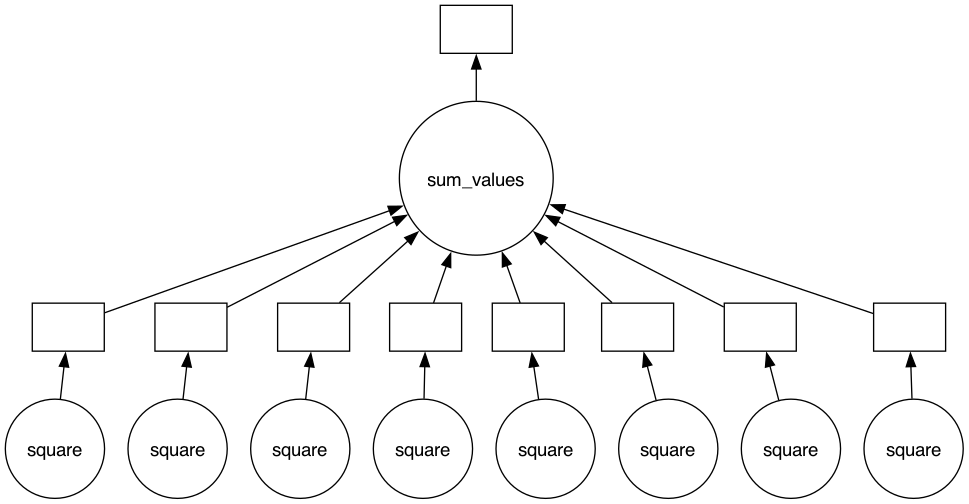

In [11]:
# Exercise solution with delayed
numbers = [1, 2, 3, 4, 5, 6, 7, 8]

@dask.delayed
def square(x):
    sleep(0.3)
    return x ** 2

@dask.delayed
def sum_values(values):
    sleep(0.2)
    return sum(values)

squared = [square(n) for n in numbers]
total = sum_values(squared)

print("Delayed approach:")
%time result_delayed = total.compute()
print("Result:", result_delayed)
total.visualize()


In [12]:
# Exercise solution with futures
def square(x):
    sleep(0.3)
    return x ** 2

def sum_values(values):
    sleep(0.2)
    return sum(values)

# Submit all square operations
futures_squared = [client.submit(square, n) for n in numbers]

# Wait for all to complete, then sum
squared_results = [f.result() for f in futures_squared]
future_sum = client.submit(sum_values, squared_results)

print("Futures approach:")
%time result_futures = future_sum.result()
print("Result:", result_futures)


Futures approach:
CPU times: user 14.4 ms, sys: 4.31 ms, total: 18.7 ms
Wall time: 215 ms
Result: 204


## Summary

**Key Takeaways:**

- **`dask.delayed`**: Lazy, graph-based, batch processing. Build a graph, optimize it, then execute with `.compute()`
- **`dask.futures`**: Eager, immediate, interactive. Submit tasks and get Future objects that execute right away
- Both are powerful for parallelizing arbitrary Python code
- Choose based on your workflow needs: graph optimization (delayed) vs real-time execution (futures)

Both approaches can significantly speed up your code when you have parallelizable work!
